In [15]:
import numpy as np
import cv2
import os
from tqdm import tqdm
from random import shuffle

TRAIN_DIR = r'C:\Users\User\Documents\Kaggle_Data\Dogs_Vs_Cats-Classification\train'
TEST_DIR = r'C:\Users\User\Documents\Kaggle_Data\Dogs_Vs_Cats-Classification\test'
IMG_SIZE = 100 
LR = 1e-3  # High LR = easy loss crucial objective, Smaller LR = can find minmax
# more conv layer takes more time
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR,'10conv-basic') #Documentation Purpose

In [16]:
def label_img(img): #Determine if img is dog/cat
    word_label = img.split('.')[-3] #Eg."Dog.69.png"
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

In [17]:
def create_train_data(): #Shuffled dataset for train model
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)): #Progress Bar
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.py',training_data) #Documentation purpose
    return training_data

In [18]:
def process_test_data(): #Shuffled datasset for test model
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)): #Progress Bar
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),img_num])
    
    np.save('test_data.npy',testing_data)
    return testing_data

In [19]:
train_data = create_train_data()
# if train data exist:
# train_data = np.load('train_data.npy')

100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [00:21<00:00, 1160.28it/s]


In [20]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

# reset graph
import tensorflow as tf
tf.compat.v1.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate= LR, loss='categorical_crossentropy', name='targets') 

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [21]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('MODEL LOADED!')

INFO:tensorflow:Restoring parameters from C:\Users\User\Documents\Kaggle_Data\Dogs_Vs_Cats-Classification\dogsvscats-0.001-10conv-basic.model
MODEL LOADED!


In [22]:
train = train_data[:-500]
test = train_data[-500:]

In [23]:
# Fit
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1) #Features set, 0 = img data
Y = [i[1] for i in train] #Labels

# Testing accuracy
test_x = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1) #Features set, 0 = img data
test_y = [i[1] for i in train] #Labels


In [24]:
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 7659  | total loss: 0.22530 | time: 148.555s
| Adam | epoch: 010 | loss: 0.22530 - acc: 0.9153 -- iter: 24448/24500
Training Step: 7660  | total loss: 0.23039 | time: 180.162s
| Adam | epoch: 010 | loss: 0.23039 - acc: 0.9081 | val_loss: 0.18876 - val_acc: 0.9227 -- iter: 24500/24500
--


In [25]:
#tensorboard --logdir=C:\Users\User\Documents\Kaggle_Data\Dogs_Vs_Cats-Classification\log

In [26]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\User\Documents\Kaggle_Data\Dogs_Vs_Cats-Classification\dogsvscats-0.001-10conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:23<00:00, 537.49it/s]


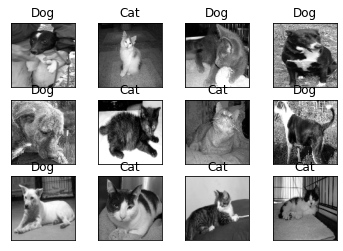

In [27]:
import matplotlib.pyplot as plt

# if dun have this file yet
test_data = process_test_data()

# if already have it
#test_data = np.load('test_data.npy')

fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label = 'Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()        

In [34]:
with open('submission-file.csv','w') as f:
    f.write('id,label\n')

In [35]:
with open('submission-file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[1]))
        

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:32<00:00, 384.58it/s]
